In [1]:
# potrebne knjiznice
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

In [2]:
# uvoz podatkov
data_A = pd.read_csv("SEEDS_TP_A+_A-.csv", index_col=0).iloc[1:,:]
data_A = data_A.apply(pd.to_numeric)
data_A.index = pd.to_datetime(data_A.index, format="%d/%m/%Y %H:%M")
data_A.index = pd.date_range(start=data_A.index[0], periods=len(data_A), freq="15T")
data_A = data_A[['TP CELJSKA CESTA 2694_A+_201', 'TP BENCINSKI SERVIS 3 2781_A+_401']]
# dodam
data_A['month'] = data_A.index.month

# 1 mesec, 2 dni za napoved
df = data_A[(data_A.index >= "2023-02-01") & (data_A.index < "2023-03-03")]
df["time"] = df.index


/var/folders/bv/jzlzr1zd4z7bc7wnb1vbjb5w0000gn/T/ipykernel_83507/2345236717.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = df.index


# ARMA modeling

In [45]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions


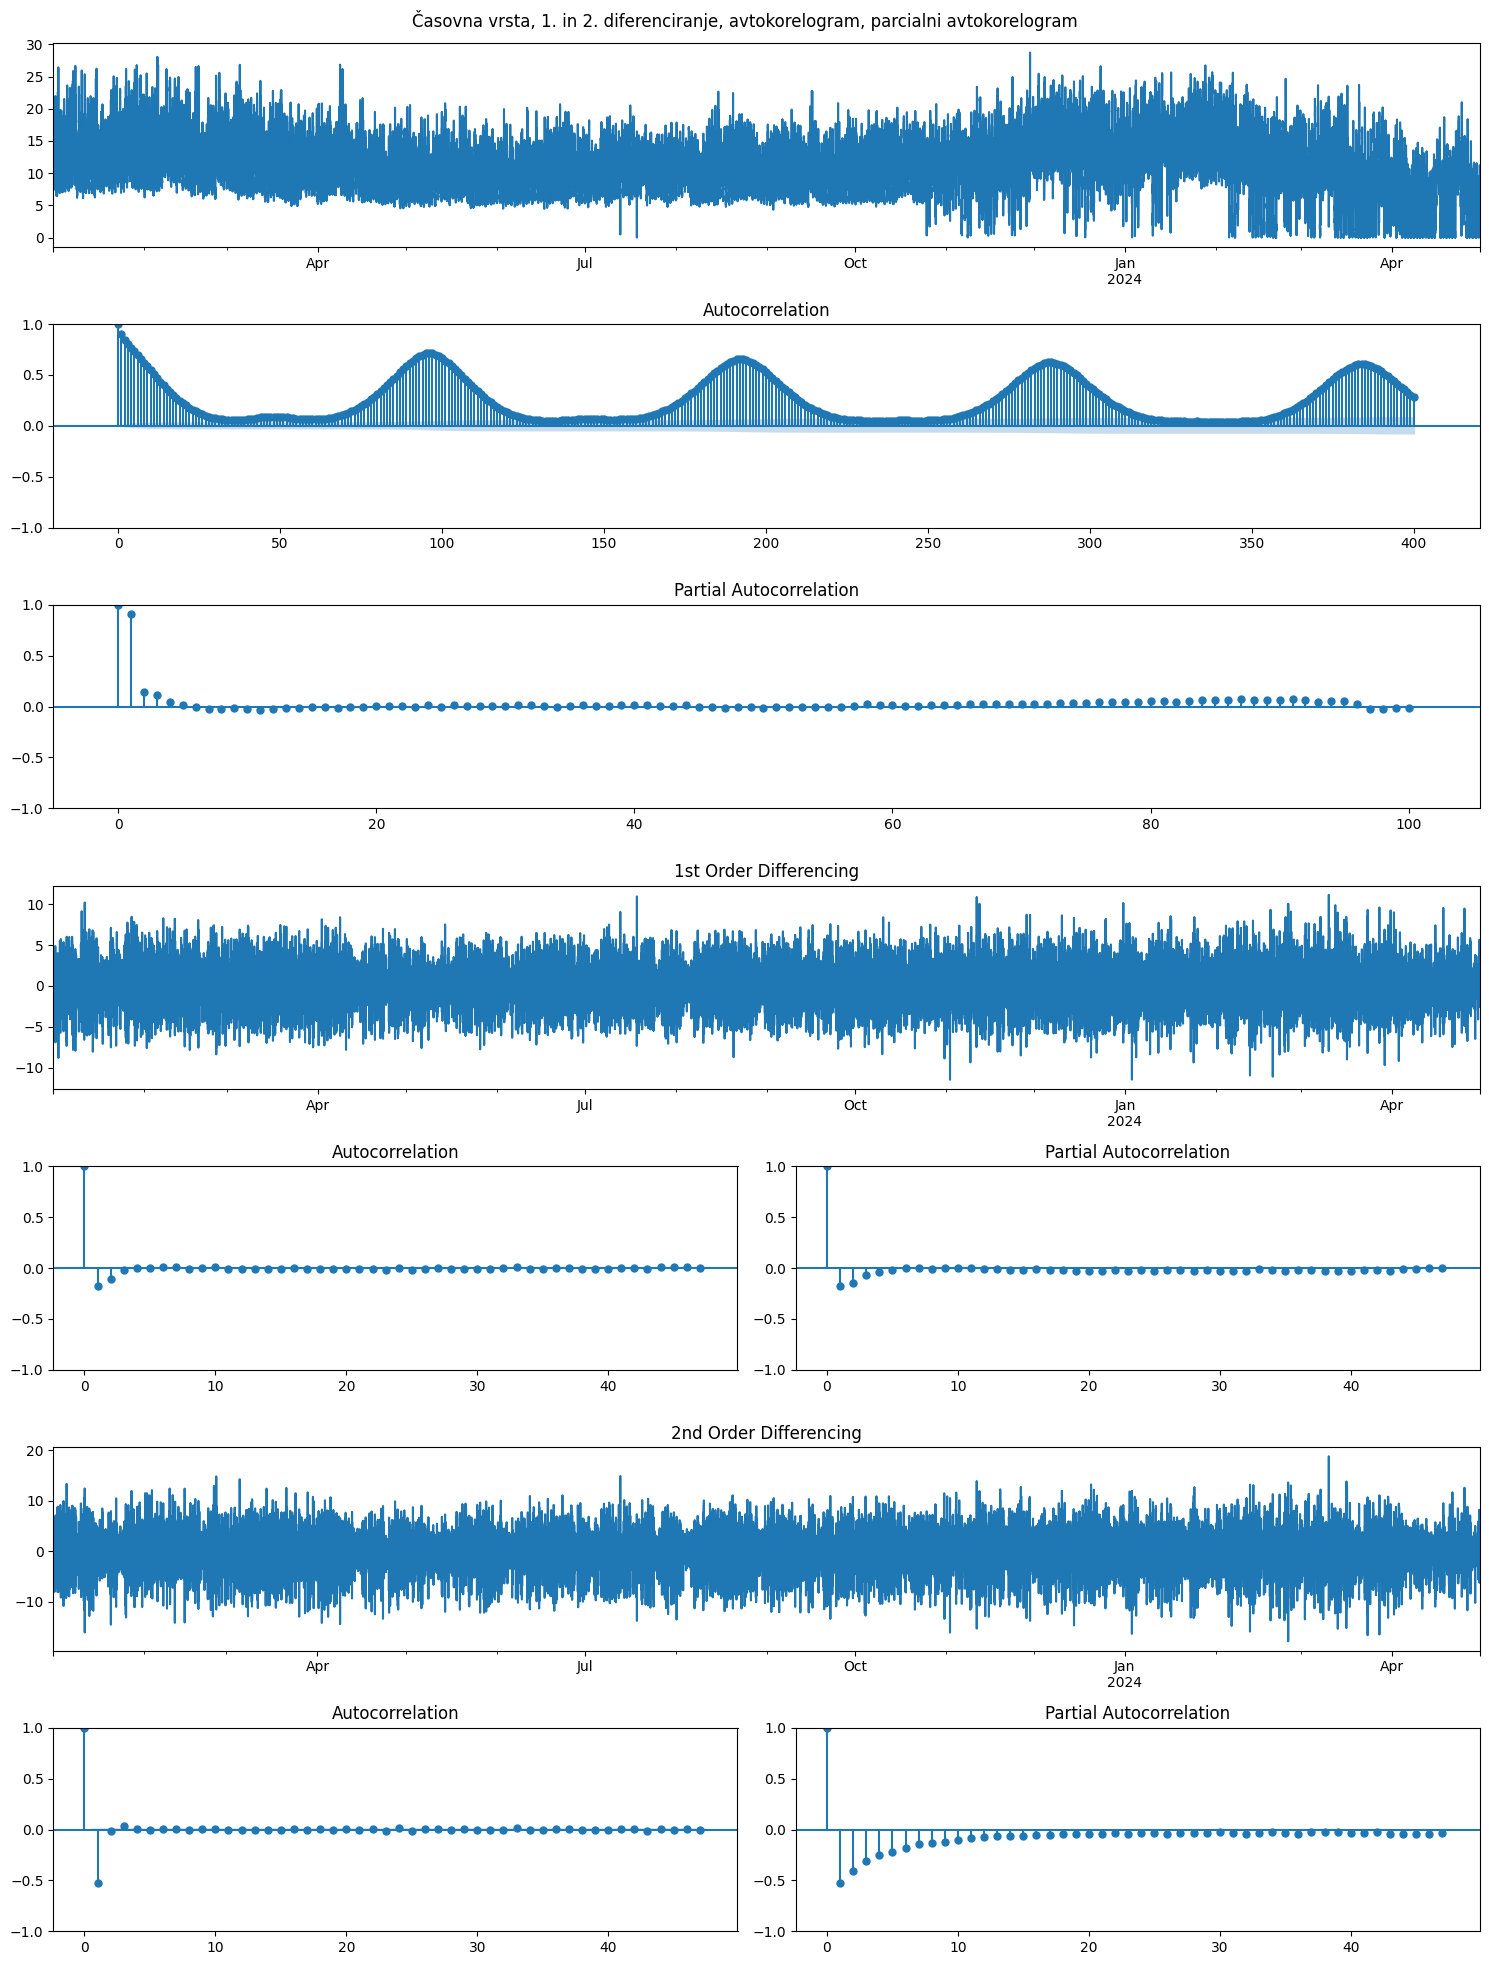

In [32]:
data = data_A[['TP BENCINSKI SERVIS 3 2781_A+_401']]
data = data.rename(columns={'TP BENCINSKI SERVIS 3 2781_A+_401': 'moc'}) # preimenovanje stolpcev

fig = plt.figure(figsize=(15, 20))
layout = (7, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
pacf_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
ts1_ax = plt.subplot2grid(layout, (3, 0), colspan=2)
acf1_ax = plt.subplot2grid(layout, (4, 0))
pacf1_ax = plt.subplot2grid(layout, (4, 1))
ts2_ax = plt.subplot2grid(layout, (5, 0), colspan=2)
acf2_ax = plt.subplot2grid(layout, (6, 0))
pacf2_ax = plt.subplot2grid(layout, (6, 1))

ts_ax.set_title(' ')
data['moc'].plot(ax=ts_ax)
smt.graphics.plot_acf(data['moc'], lags=400, ax=acf_ax)
smt.graphics.plot_pacf(data['moc'], lags=100, ax=pacf_ax)
lags=None
ts1_ax.set_title('1st Order Differencing')
data['moc'].diff().dropna().plot(ax=ts1_ax)
smt.graphics.plot_acf(data['moc'].diff().dropna(), lags=lags, ax=acf1_ax)
smt.graphics.plot_pacf(data['moc'].diff().dropna(), lags=lags, ax=pacf1_ax)
ts2_ax.set_title('2nd Order Differencing')
data['moc'].diff().diff().dropna().plot(ax=ts2_ax)
smt.graphics.plot_acf(data['moc'].diff().diff().dropna(), lags=lags, ax=acf2_ax)
smt.graphics.plot_pacf(data['moc'].diff().diff().dropna(), lags=lags, ax=pacf2_ax)

fig.suptitle('Časovna vrsta, 1. in 2. diferenciranje, avtokorelogram, parcialni avtokorelogram', fontsize=12) 
plt.tight_layout()

- vidimo, da koeficienti avtokorelacije padajo počasi 
- nihanja oz. periodničnosti koeficientov avtokorelacije 

$\Rightarrow$ **prisotnost trenda in sezonskost**

Pri diferenciranju pogledamo, če je potrebno:
- diferenciranje 1. reda: odpravimo linearni trend
- diferenciranje 2. reda: odpravimo kvadratni trend

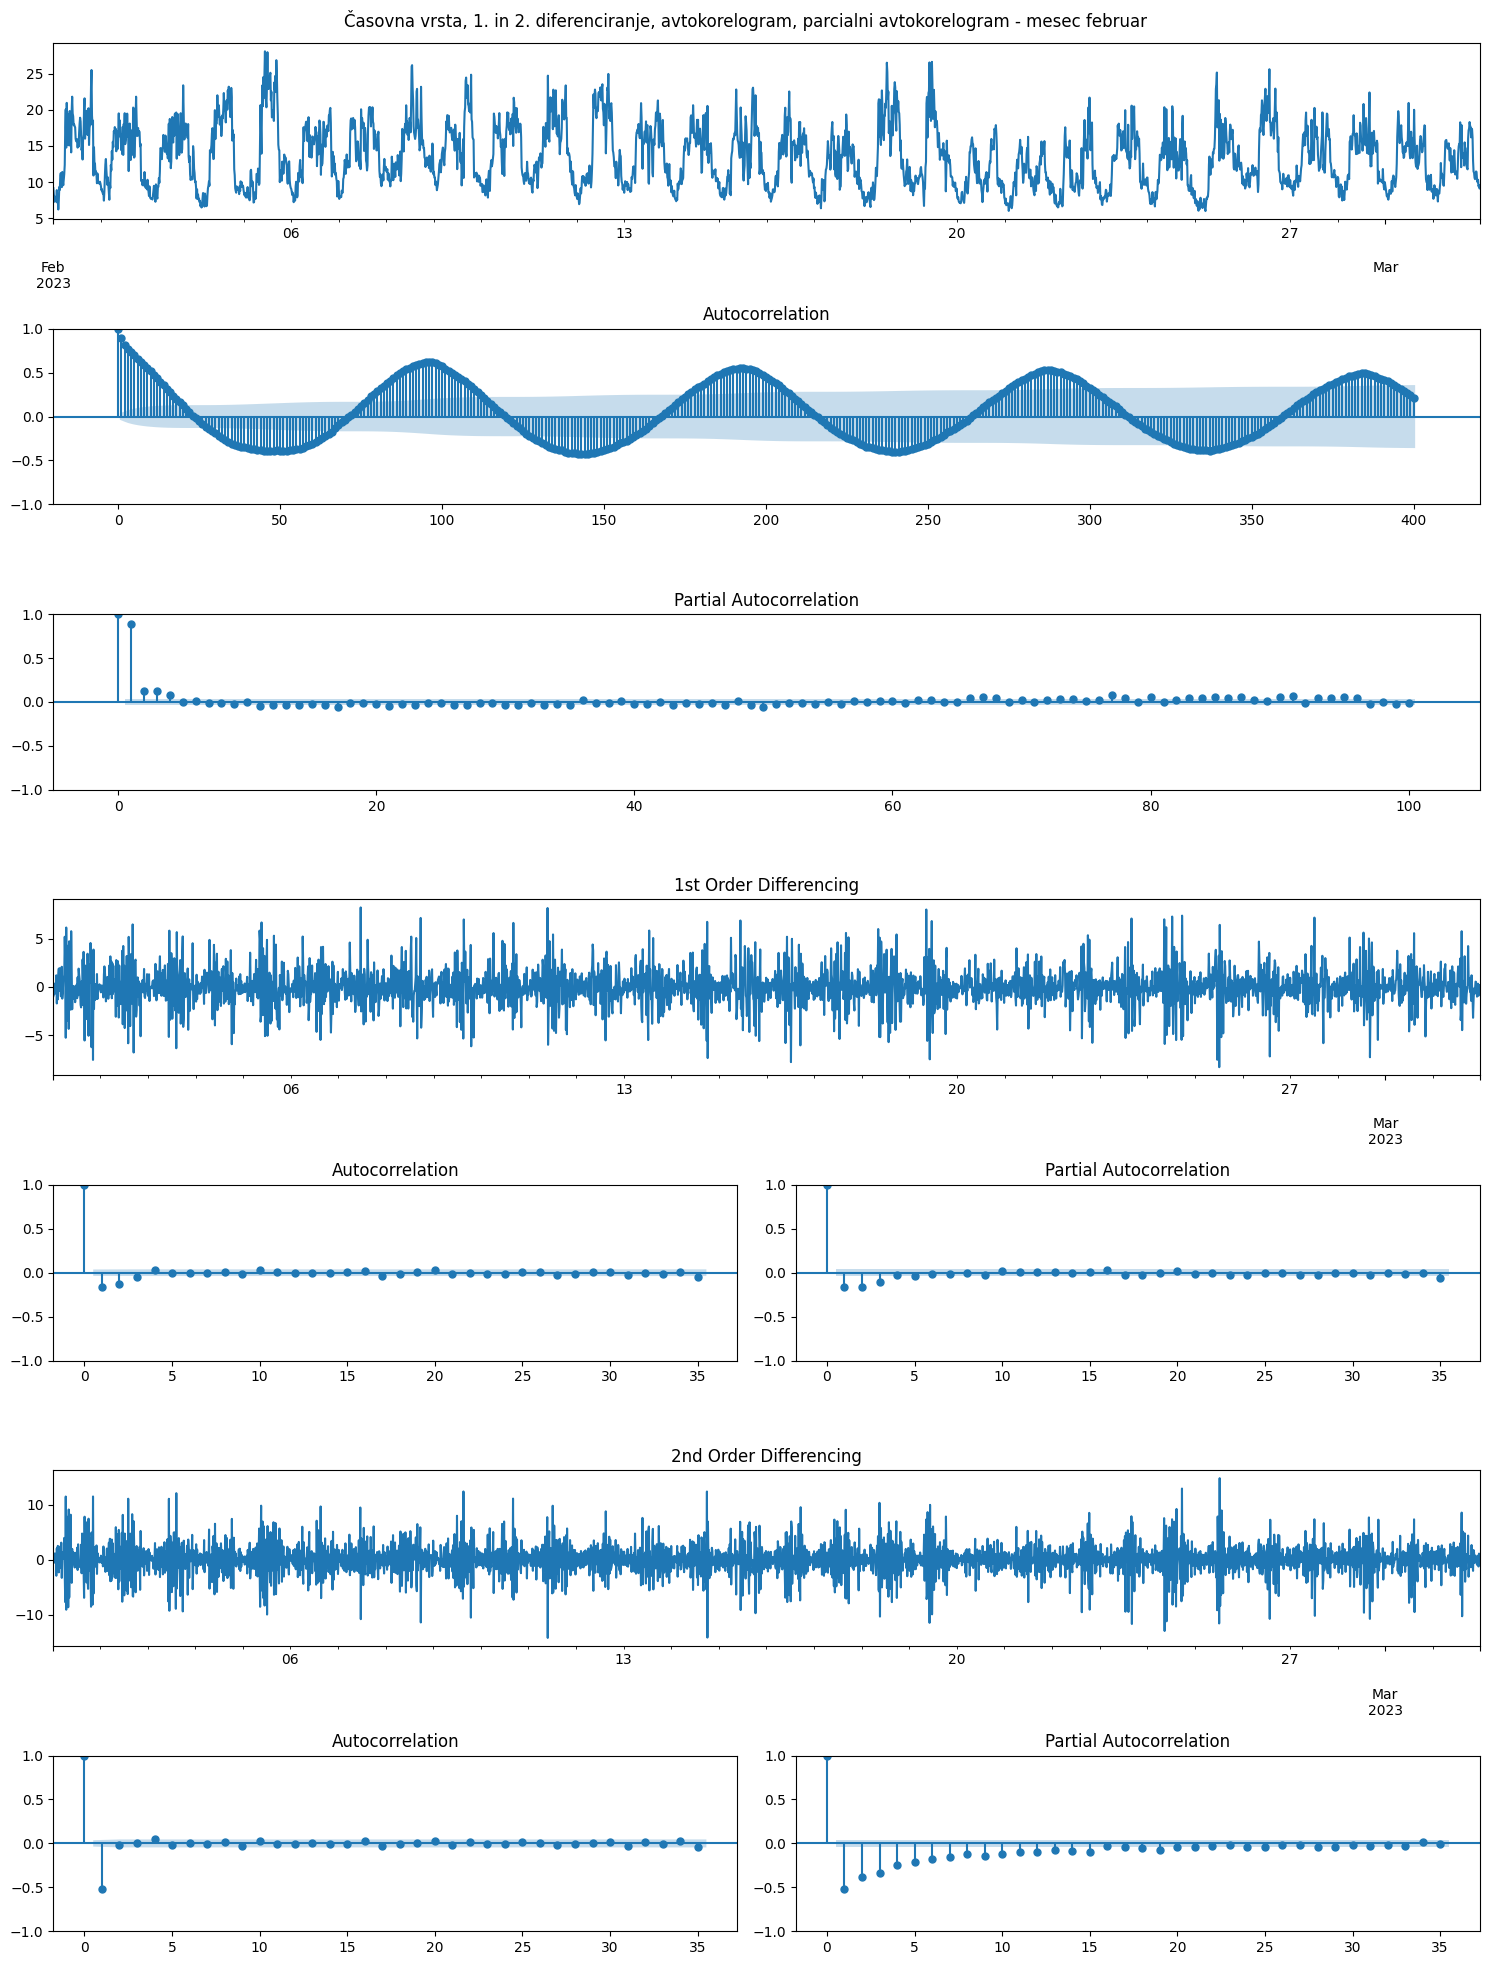

In [33]:
data = df[['TP BENCINSKI SERVIS 3 2781_A+_401']]
data = data.rename(columns={'TP BENCINSKI SERVIS 3 2781_A+_401': 'moc'}) # preimenovanje stolpcev

fig = plt.figure(figsize=(15, 20))
layout = (7, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
pacf_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
ts1_ax = plt.subplot2grid(layout, (3, 0), colspan=2)
acf1_ax = plt.subplot2grid(layout, (4, 0))
pacf1_ax = plt.subplot2grid(layout, (4, 1))
ts2_ax = plt.subplot2grid(layout, (5, 0), colspan=2)
acf2_ax = plt.subplot2grid(layout, (6, 0))
pacf2_ax = plt.subplot2grid(layout, (6, 1))

ts_ax.set_title(' ')
data['moc'].plot(ax=ts_ax)
smt.graphics.plot_acf(data['moc'], lags=400, ax=acf_ax)
smt.graphics.plot_pacf(data['moc'], lags=100, ax=pacf_ax)
lags=None
ts1_ax.set_title('1st Order Differencing')
data['moc'].diff().dropna().plot(ax=ts1_ax)
smt.graphics.plot_acf(data['moc'].diff().dropna(), lags=lags, ax=acf1_ax)
smt.graphics.plot_pacf(data['moc'].diff().dropna(), lags=lags, ax=pacf1_ax)
ts2_ax.set_title('2nd Order Differencing')
data['moc'].diff().diff().dropna().plot(ax=ts2_ax)
smt.graphics.plot_acf(data['moc'].diff().diff().dropna(), lags=lags, ax=acf2_ax)
smt.graphics.plot_pacf(data['moc'].diff().diff().dropna(), lags=lags, ax=pacf2_ax)

fig.suptitle('Časovna vrsta, 1. in 2. diferenciranje, avtokorelogram, parcialni avtokorelogram - mesec februar', fontsize=12) 
plt.tight_layout()

## MA(q), AR(p)

Na podlagi grafov:

$q$ = 3, 4

$p$ = 3

In [37]:
# nastavim meje za p in q
p = range(2, 4)
d = range(0,2)
q = range(2, 5)

# mozne kombinacije parametrov
parameters = product(p, d, q)
parameters_list = list(parameters)

SARIMA modeli zahtevajo, da so podatki stacionarni (konstantna pricakovana vrednost, varianca in avtokorelacija skozi čas). 

In [69]:
def optimizeARIMA(parameters_list):
    """
        Tabela z parametri (p,d,q) in pripadajocim AIC za model ARIMA(p,d,q)
        
        parameters_list - seznam (p,d,q)
    """
    
    results = []
    best_aic = float("inf")

    for param in parameters_list:
        # try-except zaradi stacionarnosti
        try:
            model = ARIMA(data.moc, order=(param[0], param[1], param[2])).fit()
        except:
            continue

        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=False).reset_index(drop=True)
    
    return result_table

In [70]:
result_table = optimizeARIMA(parameters_list)

/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

In [74]:
p, d, q= result_table.parameters[0]
best_model = ARIMA(data.moc, order=(p, d, q)).fit()
print(best_model.summary())

/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nezakrzan/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    moc   No. Observations:                 2880
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -5887.639
Date:                Mon, 20 May 2024   AIC                          11791.278
Time:                        13:04:55   BIC                          11839.000
Sample:                    02-01-2023   HQIC                         11808.479
                         - 03-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0526      1.743     -0.030      0.976      -3.469       3.364
ar.L2         -0.1239      0.705     -0.176      0.861      -1.506       1.258
ar.L3          0.0899      0.160      0.562      0.5

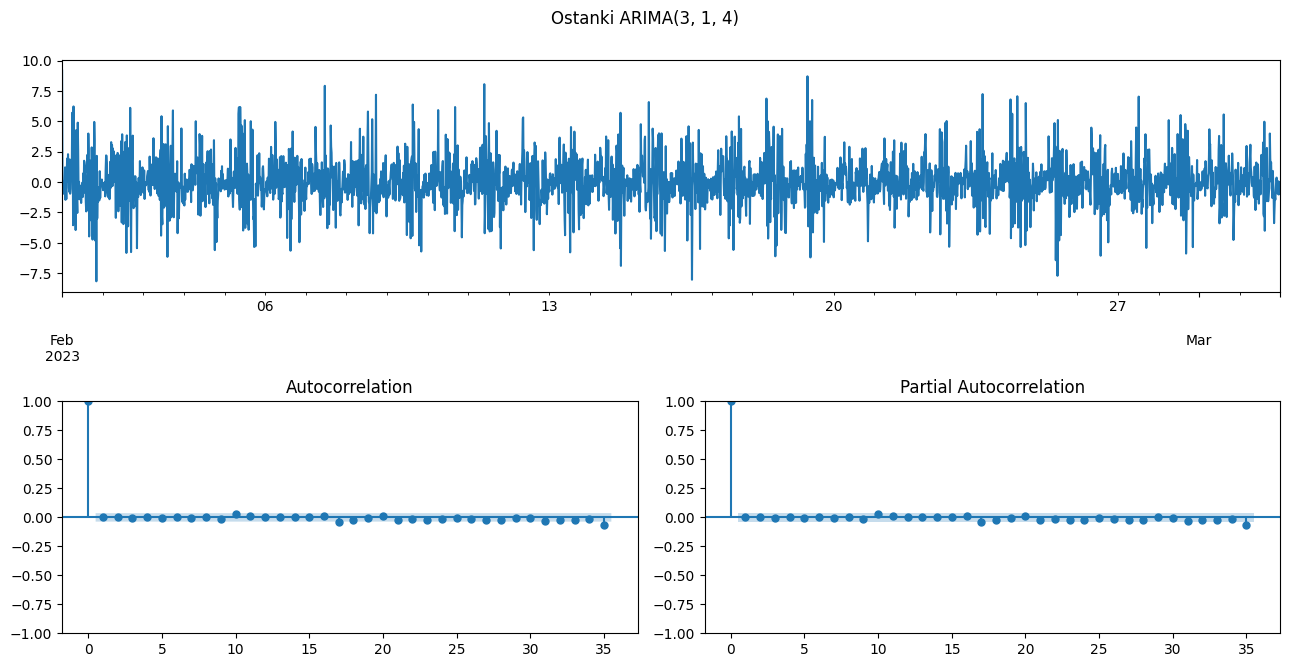

In [84]:
data = best_model.resid

fig = plt.figure(figsize=(13, 10))
layout = (3, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))


ts_ax.set_title(' ')
data.plot(ax=ts_ax)
smt.graphics.plot_acf(data, lags=None, ax=acf_ax)
smt.graphics.plot_pacf(data, lags=None, ax=pacf_ax)


fig.suptitle('Ostanki ARIMA(3, 1, 4)', fontsize=12) 
plt.tight_layout()